In [1]:
from sklearn.datasets import fetch_mldata

In [2]:
mnist = fetch_mldata('MNIST original')

In [3]:
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [4]:
X, y = mnist['data'], mnist['target']

In [5]:
print("shape:", X.shape, y.shape)

shape: (70000, 784) (70000,)


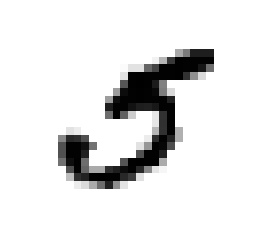

5.0

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()
y[36000]

In [7]:
# split train and test
X_train, X_test, y_train, y_test = X[:60000], X[60000:],y[:60000],y[60000:]

In [8]:
# shuffle data
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [9]:
# binary classifier
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [10]:
# SGD classifier
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42,tol=1e-3)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=0.001, verbose=0, warm_start=False)

In [11]:
sgd_clf.predict([some_digit])

array([False])

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95065
0.96015
0.96285


In [13]:
# using cross_val_score()
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95065, 0.96015, 0.96285])

In [14]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')
# skewed dataset, 10% is 5 and 90% is non-5

array([0.90875, 0.9087 , 0.9115 ])

In [16]:
# confusion matrix
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53931,   648],
       [ 1879,  3542]])

In [17]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.845346062052506

In [18]:
recall_score(y_train_5, y_train_pred)

0.6533849843202362

In [19]:
# f1 score
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7370721048798252

In [20]:
y_scores = sgd_clf.decision_function([some_digit])

In [21]:
y_scores

array([-5303.64997281])

In [22]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [23]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [24]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

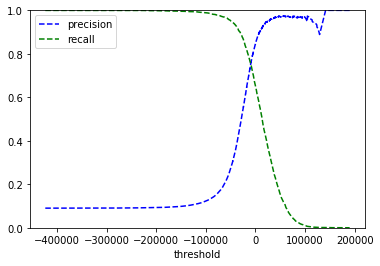

In [25]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label='recall')
    plt.xlabel('threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [26]:
# ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

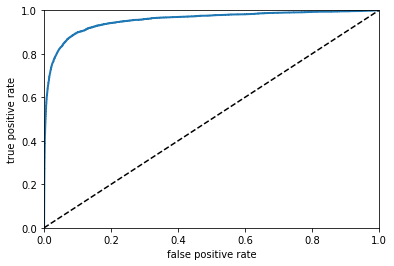

In [27]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')

plot_roc_curve(fpr, tpr)
plt.show()

In [28]:
# compute AUC
# AUC of perfect classifier is 1 and AUC of random classifier is 0.5
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9550643423715801

In [29]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [30]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

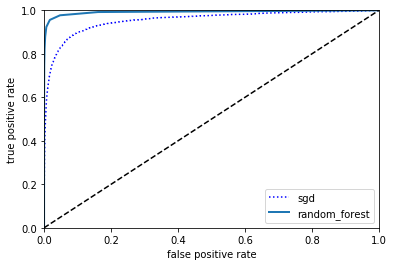

In [31]:
plt.plot(fpr, tpr, 'b:', label='sgd')
plot_roc_curve(fpr_forest, tpr_forest, 'random_forest')
plt.legend(loc='lower right')
plt.show()

In [32]:
# multiclass classification
# svm use one-versus-one strategy
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3.])

In [33]:
some_digit_score = sgd_clf.decision_function([some_digit])
some_digit_score

array([[ -27838.6531345 ,  -67126.48914955,  -71506.35960406,
           2240.61392231,  -69071.15108866,   -5303.64997281,
        -127028.2231199 ,  -89921.29804334,  -47010.30647796,
         -71989.80750532]])

In [34]:
np.argmax(some_digit_score)

3

In [35]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [36]:
# train one-vs-one classifier
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42, tol=1e-3))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5.])

In [37]:
len(ovo_clf.estimators_)

45

In [38]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5.])

In [39]:
forest_clf.predict_proba([some_digit])

array([[0.1, 0. , 0. , 0.1, 0. , 0.8, 0. , 0. , 0. , 0. ]])

In [40]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.88317337, 0.87229361, 0.86898035])

In [41]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.90356929, 0.90339517, 0.90508576])

In [42]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5619,    0,   17,    5,    9,   48,   37,    6,  181,    1],
       [   0, 6417,   41,   27,    3,   41,    6,    9,  188,   10],
       [  22,   27, 5269,   98,   73,   23,   67,   42,  326,   11],
       [  23,   23,  114, 5285,    0,  209,   24,   48,  343,   62],
       [  10,   16,   41,   12, 5256,    9,   37,   21,  265,  175],
       [  27,   20,   28,  170,   54, 4525,   83,   19,  425,   70],
       [  32,   19,   50,    4,   42,   89, 5555,    8,  119,    0],
       [  21,   13,   54,   23,   56,    9,    5, 5736,  139,  209],
       [  17,   69,   41,  108,    1,  120,   27,    9, 5417,   42],
       [  24,   23,   34,   60,  117,   39,    1,  180,  309, 5162]])

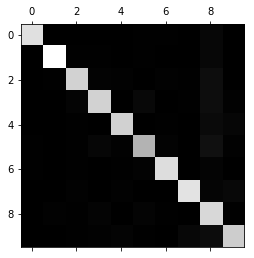

In [43]:
# confusion matrix as image
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [44]:
# plot error image
# row is actual class
# col is prediction
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

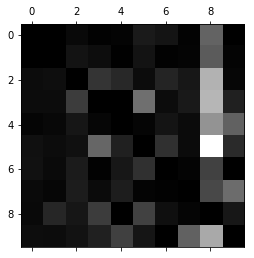

In [45]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [46]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

In [47]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

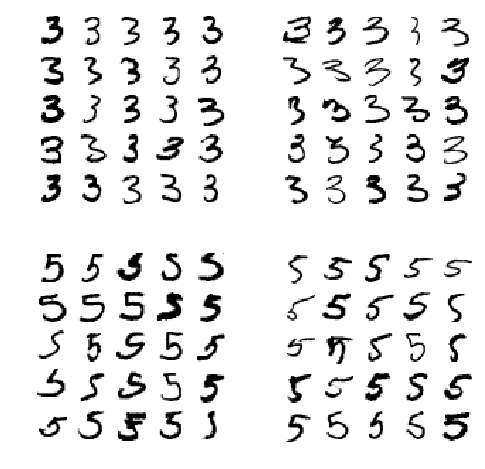

In [48]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [49]:
# multilabel classification
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [50]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [ ]:
# average f1 score for multilabel problem
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average='macro')

In [ ]:
# add noise to MNIST image
noise = rnd.randint(0, 100, (len(X_train), 784))
noise = rnd.randint(0, 100, (len(X_test), 784))
X_train_mod = X_train + noise
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
